In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ruptures.detection import Pelt
import ruptures as rpt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os
# Get the directory of the current notebook
current_dir = os.path.dirname(os.path.abspath('../scripts')) 

# Add the 'scripts' directory to the Python path
scripts_dir = os.path.join(current_dir, 'scripts')
sys.path.append(scripts_dir)

# Data Exploration

In [3]:
# Load data
data = pd.read_csv('..\data\BrentOilPrices.csv', parse_dates=['Date'], dayfirst=True)

In [4]:
# Display first few rows
data.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [5]:
data.shape

(9011, 2)

In [6]:
# Check for missing values
data.isnull().sum()

Date     0
Price    0
dtype: int64

In [7]:
# check the data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9011 non-null   datetime64[ns]
 1   Price   9011 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 140.9 KB


In [8]:
# Check for negative prices
negative_prices = data[data['Price'] < 0]
print("Negative Prices:\n", negative_prices)

Negative Prices:
 Empty DataFrame
Columns: [Date, Price]
Index: []


In [9]:
# Check for zero prices
zero_prices = data[data['Price'] == 0]
print("Zero Prices:\n", zero_prices)

Zero Prices:
 Empty DataFrame
Columns: [Date, Price]
Index: []


In [10]:
from data_analysis import analyze_and_plot_prices

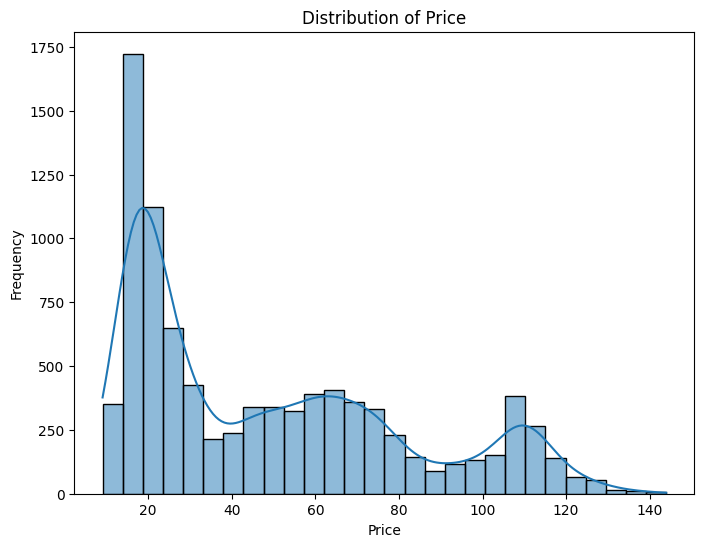

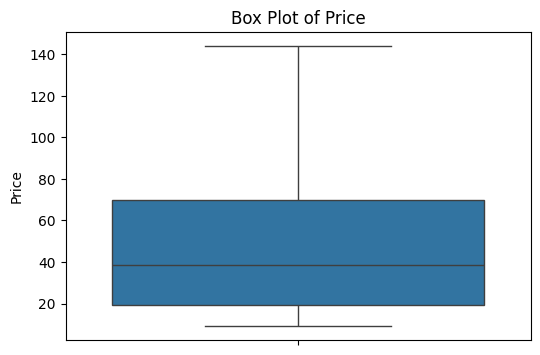

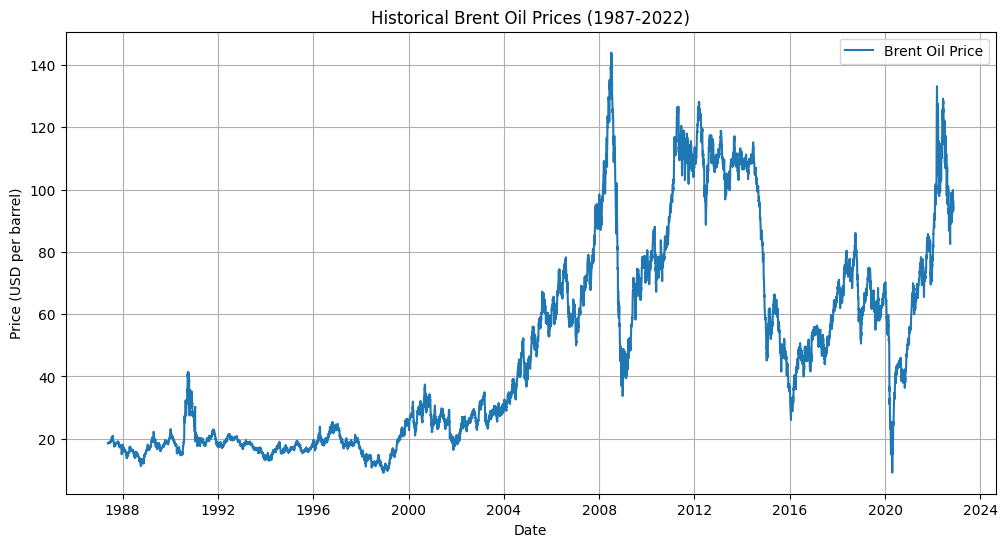

In [11]:
analyze_and_plot_prices(data)

In [12]:
from data_analysis import analyze_and_plot_time_series

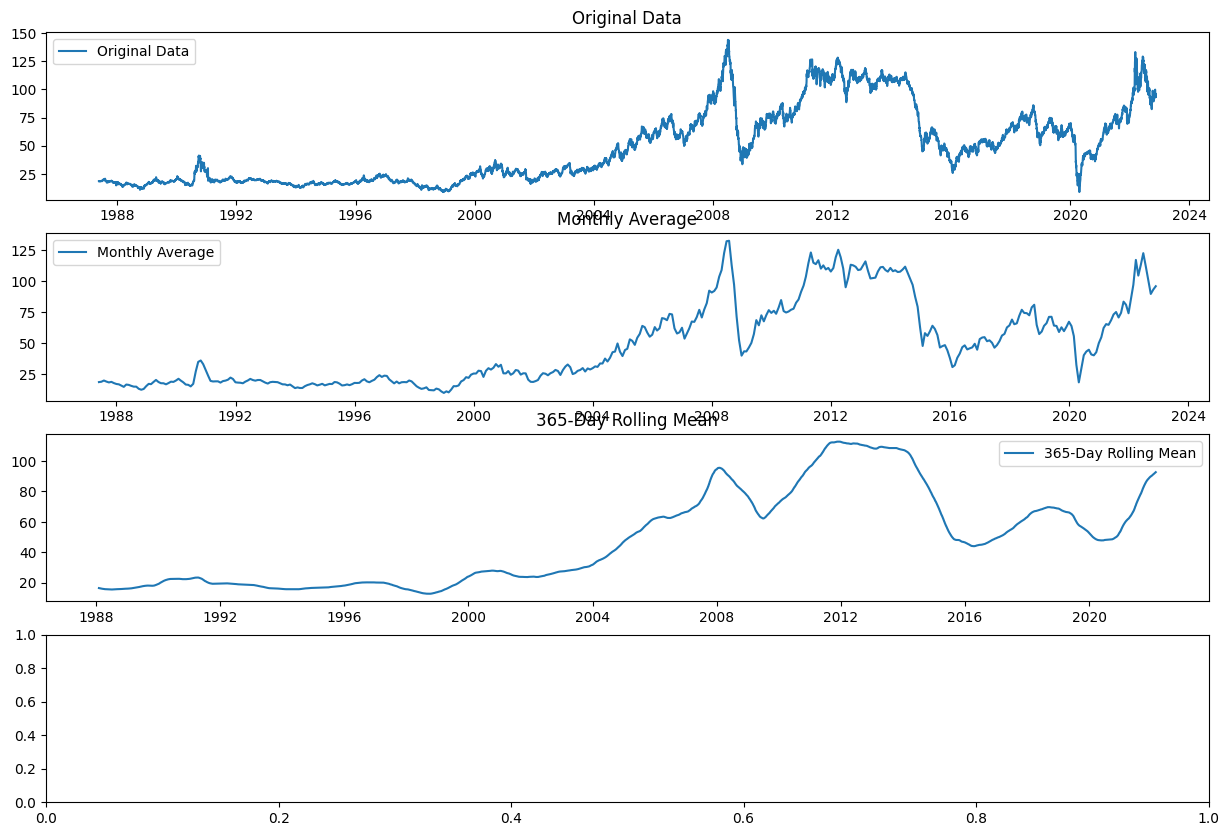

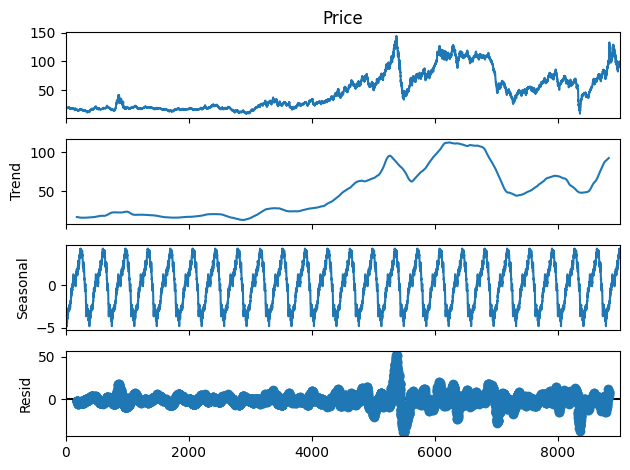

In [13]:
analyze_and_plot_time_series(data, window=365, period=365, model='additive')

In [14]:
data = data.set_index('Date')

In [15]:
# Set the frequency to daily
data = data.resample('D').ffill()

## Stationarity Check

In [16]:
# Perform ADF test
result = adfuller(data['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret the result
if result[1] <= 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -1.9488216105940648
p-value: 0.3094536250793654
Critical Values:
   1%: -3.4308561991797255
   5%: -2.8617637154959716
   10%: -2.566889078817277
The data is non-stationary (fail to reject the null hypothesis).


In [17]:
# Apply differencing
data['Price_diff'] = data['Price'].diff().dropna()

In [18]:
# drop naa
data = data.dropna()

# Change Point Analysis

In [19]:
# Convert prices to numpy array
prices = data['Price'].values

In [20]:
# Detect change points
algo = rpt.Pelt(model="rbf").fit(prices)
change_points = algo.predict(pen=10)  # Adjust penalty parameter as needed

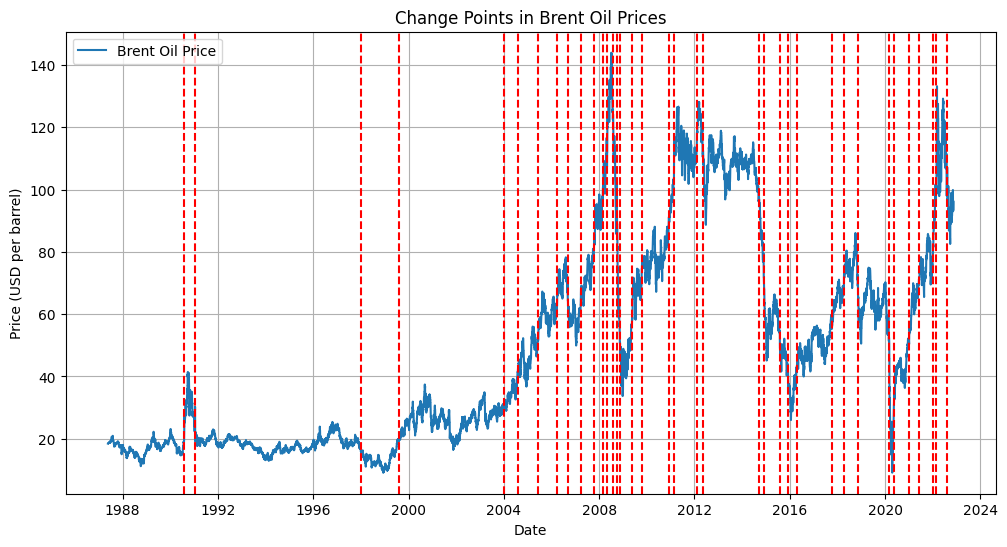

In [21]:
# Plot change points
plt.figure(figsize=(12, 6))
plt.plot(data.index, prices, label='Brent Oil Price')
for cp in change_points[:-1]:
    plt.axvline(x=data.index[cp], color='r', linestyle='--')
plt.title('Change Points in Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.grid()
plt.show()

# Time Series Modeling

In [22]:
# Fit ARIMA model
model_arima = ARIMA(data['Price'], order=(5, 1, 0))  # Adjust order as needed
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                12962
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -18565.058
Date:                Fri, 21 Feb 2025   AIC                          37142.116
Time:                        19:19:02   BIC                          37186.934
Sample:                    05-21-1987   HQIC                         37157.093
                         - 11-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0067      0.005      1.420      0.156      -0.003       0.016
ar.L2         -0.0249      0.005     -5.025      0.000      -0.035      -0.015
ar.L3          0.0154      0.005      3.243      0.0

In [23]:
# Fit GARCH model
model_garch = arch_model(data['Price'], vol='Garch', p=1, q=1)  # Adjust p and q as needed
results_garch = model_garch.fit()
print(results_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 291304349629.7299
Iteration:      2,   Func. Count:     12,   Neg. LLF: 29130372675.343693
Iteration:      3,   Func. Count:     19,   Neg. LLF: 211461.37107680028
Iteration:      4,   Func. Count:     27,   Neg. LLF: 87665.33993754309
Iteration:      5,   Func. Count:     35,   Neg. LLF: 55231.75595063607
Iteration:      6,   Func. Count:     41,   Neg. LLF: 62823.68108473826
Iteration:      7,   Func. Count:     47,   Neg. LLF: 55521.84519079768
Iteration:      8,   Func. Count:     53,   Neg. LLF: 60738.23769940108
Iteration:      9,   Func. Count:     59,   Neg. LLF: 53711.462509266654
Iteration:     10,   Func. Count:     65,   Neg. LLF: 50301983719.77193
Iteration:     11,   Func. Count:     71,   Neg. LLF: 70114.36917580916
Iteration:     12,   Func. Count:     77,   Neg. LLF: 50931.96125685358
Iteration:     13,   Func. Count:     82,   Neg. LLF: 51732.999579150615
Iteration:     14,   Func. Count:     91,   Neg. LLF: 253451

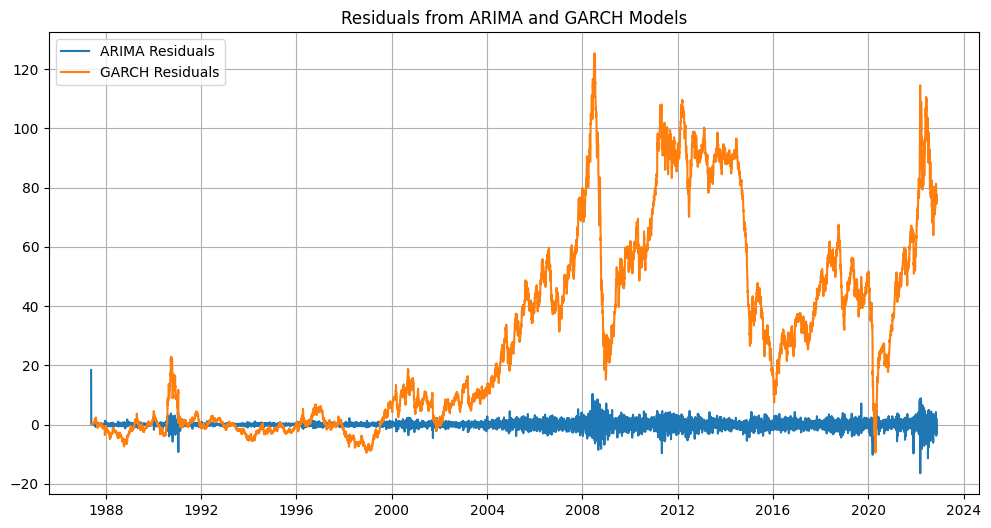

In [24]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(results_arima.resid, label='ARIMA Residuals')
plt.plot(results_garch.resid, label='GARCH Residuals')
plt.title('Residuals from ARIMA and GARCH Models')
plt.legend()
plt.grid()
plt.show()